In [1]:
!nvidia-smi
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

Fri Sep  8 18:18:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:19:00.0 Off |                  N/A |
| 30%   26C    P8    22W / 350W |  12108MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
| 30%   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# os.environ['http_proxy'] = "http://127.0.0.1:3128"
# os.environ['https_proxy'] = "http://127.0.0.1:3128"

In [3]:
import torch
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertEncoder

import matplotlib.pyplot as plt
from torch.utils.data import Dataset
torch.cuda.empty_cache()
import numpy as np
import pandas as pd
import os
import math

from typing import Callable
import functools
from pathlib import Path
import random


from tqdm.auto import tqdm

from scipy import signal
import pandas as pd
import seaborn as sns

In [4]:
from torch.utils.tensorboard import SummaryWriter

In [5]:
channels = ['Fp1', 'Fp2', 'FZ', 'FCz', 'Cz', 'Pz', 'O1', 'O2', 'F3', 'F4', 
               'F7', 'F8', 'C3', 'C4', 'T3', 'T4', 'P3', 'P4', 'T5', 'T6', 'A1', 'A2']
channels = [i.upper() for i in channels]
print(channels)


path10 = Path('/media/hdd/pretraining/synt_data/data_10')
path12 = Path('/media/hdd/pretraining/synt_data/data_12')

['FP1', 'FP2', 'FZ', 'FCZ', 'CZ', 'PZ', 'O1', 'O2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'T3', 'T4', 'P3', 'P4', 'T5', 'T6', 'A1', 'A2']


In [6]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        position = (position.T - position).T / max_len
        self.register_buffer('rel_position', position)
        
        self.conv = torch.nn.Conv1d(max_len, d_model, 25, padding=25 // 2, groups=16)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        rel_pos = self.conv(self.rel_position[:x.size(1), :x.size(1)][None])[0].T
        # print(rel_pos.shape)
        x = x + rel_pos
        return self.dropout(x)
    
class TransposeCustom(torch.nn.Module):
    def __init__(self):
        super(TransposeCustom, self).__init__()
        
    def forward(self, x):
        return torch.transpose(x, 1, 2)
    
def _make_span_from_seeds(seeds, span, total=None):
    inds = list()
    for seed in seeds:
        for i in range(seed, seed + span):
            if total is not None and i >= total:
                break
            elif i not in inds:
                inds.append(int(i))
    return np.array(inds)

def _make_mask(shape, p, total, span, allow_no_inds=False):
    # num_mask_spans = np.sum(np.random.rand(total) < p)
    # num_mask_spans = int(p * total)
    mask = torch.zeros(shape, requires_grad=False, dtype=torch.bool)

    for i in range(shape[0]):
        mask_seeds = list()
        while not allow_no_inds and len(mask_seeds) == 0 and p > 0:
            mask_seeds = np.nonzero(np.random.rand(total) < p)[0]

        mask[i, _make_span_from_seeds(mask_seeds, span, total=total)] = True

    return mask

In [7]:
class EEGEmbedder(torch.nn.Module):
    def __init__(self, num_labels=2, channels=None, clf=True):
        super(EEGEmbedder, self).__init__()
        self.config = BertConfig(is_decoder=False, 
                    add_cross_attention=False,
                    ff_layer='linear',
                    hidden_size=512,
                    num_attention_heads=8,
                    num_hidden_layers=8,
                    conv_kernel=1,
                    conv_kernel_num=1)
        self.channels = channels
        self.model = BertEncoder(self.config)

        self.clf = clf
        self.masking = True
        
        
        self.pos_e = PositionalEncoding(512, max_len=6000)
        self.ch_embedder = torch.nn.Embedding(22, 512)
        self.ch_norm = torch.nn.LayerNorm(512)
        
        self.input_norm = torch.nn.LayerNorm(2)
        self.input_embedder = torch.nn.Sequential(
            TransposeCustom(),
            torch.nn.Conv1d(21, 32, 5, 2, padding=0),
            torch.nn.Conv1d(32, 64, 5, 2, padding=0),
            # TransposeCustom(),
            torch.nn.GroupNorm(64 // 2, 64),
            torch.nn.GELU(),
            # TransposeCustom(),
            torch.nn.Conv1d(64, 128, 3, 2, padding=0),
            torch.nn.Conv1d(128, 196, 3, 2, padding=0),
            # TransposeCustom(),
            torch.nn.GroupNorm(196 // 2, 196),
            torch.nn.GELU(),
            # TransposeCustom(),
            torch.nn.Conv1d(196, 256, 5, 1, padding=0),
            torch.nn.Conv1d(256, 384, 5, 1, padding=0),
            # TransposeCustom(),
            torch.nn.GroupNorm(384 // 2, 384),
            torch.nn.GELU(),
            # TransposeCustom(),
            torch.nn.Conv1d(384, 512, 5, 1, padding=0),
            torch.nn.Conv1d(512, 512, 1, 1, padding=0),
            torch.nn.GroupNorm(512 // 2, 512),
            torch.nn.GELU(),
            TransposeCustom(),
        # torch.nn.LeakyReLU(),
        )
        
        self.output_embedder = torch.nn.Linear(512, 512)
        self.transpose = TransposeCustom()
        
        self.mask_embedding = torch.nn.Parameter(torch.normal(0, 512**(-0.5), size=(512,)),
                                                   requires_grad=True)
        self.placeholder = torch.nn.Parameter(torch.normal(0, 512**(-0.5), size=(512,)),
                                                   requires_grad=True)
        # self.classifier = torch.nn.Linear()
        
        self.classifier = torch.nn.Sequential(
            # torch.nn.Linear(768, 256),
            torch.nn.Linear(self.config.hidden_size, self.config.num_labels),
            # torch.nn.Linear(256, 2),
            torch.nn.Sigmoid()
        )
        
    def forward(self, inputs, attention_mask, ch_vector, clf=False):
        embedding = self.input_embedder(inputs)
        # create embedding for two channel indexes and sumup them to a single one
        ch_embedding = self.ch_embedder(ch_vector).sum(1)
        ch_embedding = ch_embedding[:, None]
        embedding += ch_embedding
        embedding_unmasked = embedding.clone() # keep for loss calculation
        # perform masking
        if self.masking:
            mask = _make_mask((embedding.shape[0], embedding.shape[1]), 0.05, embedding.shape[1], 10)
            embedding[mask] = self.mask_embedding
        
        # additional vector for classification tasks later
        placeholder = torch.zeros((embedding.shape[0], 1, embedding.shape[2]), device=embedding.device)
        placeholder += self.placeholder
        embedding = torch.cat([placeholder, embedding], 1)
        encoder_output = self.model(embedding, output_hidden_states=True,
                               output_attentions=True)[0]
    
        encoder_output = self.output_embedder(encoder_output)

        if clf:
            logits = self.classifier(encoder_output[:, 0]) #sequence classification
            # logits = self.classifier(encoder_output)  # token classification ?
            return logits
            
        
        return encoder_output[:, 1:], embedding_unmasked
    
    


In [8]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    np.random.seed((torch_seed + worker_id) % 2**30)
    
    
def _SelectChannels(sample, channels=channels):
    signal = sample['value_pure']
    channels_ids = [i for i, val in enumerate(sample['channels']) if i != 3 and val in channels]
    channels_to_train = channels_ids
    # print(signal.shape)
    signal = signal[:, channels_to_train]
    # print(signal.shape)
    
    return signal, channels_to_train


def SleepEdf():
    sample_ch = sample['channels']
    return
    

class TEST(torch.utils.data.Dataset):
    def __init__(self, paths, labels=None, return_label=False, masking=True, preprocess_montage:Callable=_SelectChannels) :
        super(TEST, self).__init__()
        self.paths = paths
        self.labels = labels
        self.return_label = return_label
        self.masking = masking
        self.preprocess_montage=preprocess_montage
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        # take 60s of recording with specified shift
        sample = np.load(path, allow_pickle=True).item()
        return self.process_sample(sample, label=self.labels[idx])
        
    def process_sample(self, sample, label=None):
        signal, channels_to_train = self.preprocess_montage(sample)
        real_len = signal.shape[0]

        channels_vector = torch.tensor((channels_to_train))

        sample_norm_mean = signal.mean()
        sample_norm_std = np.std(signal)
        
        signal_norm = (signal - sample_norm_mean) / (sample_norm_std)
        attention_mask=np.arange(1)
        if self.masking:
            if signal_norm.shape[0] < 6000:
                signal_norm = np.pad(signal_norm, ((0, 6000 - signal_norm.shape[0]), (0, 0)))

            attention_mask = torch.ones(6000)
            attention_mask[real_len:] = 0
        output =  {'anchor': torch.from_numpy(signal_norm).float(), 
                # 'anchor_masked': torch.from_numpy(sample_masked).float(), 
                # 'mask': torch.tensor(mask),
                'channels': channels_vector,
                'attention_mask': attention_mask}
        if label is not None:
            output['label'] = label
        return output
            
    
class SYNT(TEST):
    def __init__(self, paths, labels, return_label=True, masking=True, preprocess_montage:Callable=_SelectChannels) :
        super(SYNT, self).__init__(paths, labels, return_label=True, masking=True, preprocess_montage=preprocess_montage)
# 
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        # take 60s of recording with specified shift
        sample = np.load(path, allow_pickle=True).T
        sample = {'value_pure':sample, 'channels':channels}
        
        return self.process_sample(sample, label=self.labels[idx])

    
#     def process_sample(self, sample, label=None):
#         signal, channels_to_train = self.preprocess_montage(sample)
#         real_len = signal.shape[0]

#         channels_vector = torch.tensor((channels_to_train))

#         sample_norm_mean = signal.mean()
#         sample_norm_std = np.std(signal)
        
#         signal_norm = (signal - sample_norm_mean) / (sample_norm_std)
#         attention_mask=np.arange(1)
# #         if signal_norm.shape[0] < 6000:
# #             signal_norm = np.pad(signal_norm, ((0, 6000 - signal_norm.shape[0]), (0, 0)))
        
# #         attention_mask = torch.ones(6000)
# #         attention_mask[real_len:] = 0
#         output =  {'anchor': torch.from_numpy(signal_norm).float(), 
#                 # 'anchor_masked': torch.from_numpy(sample_masked).float(), 
#                 # 'mask': torch.tensor(mask),
#                 'channels': channels_vector,
#                 'attention_mask': attention_mask}
#         if label is not None:
#             output['label'] = label
#         return output

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device='cpu'

In [10]:
class_size = 1000
batch_size = 10

paths_train = list(path10.glob("*.npy"))[:class_size] + list(path12.glob("*.npy"))[:class_size] # first n samples
labels = np.r_[np.ones(class_size), np.zeros(class_size)]
labels = torch.tensor(labels).cuda()
if 'cuda' in device:
    labels = labels.cuda()
    
synt_dataset_train = SYNT(paths_train, labels=labels, masking=False)
synt_loader_train = torch.utils.data.DataLoader(synt_dataset_train, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True, worker_init_fn=worker_init_fn)

paths_test = list(path10.glob("*.npy"))[-class_size:] + list(path12.glob("*.npy"))[-class_size:] # last n samples
labels = np.r_[np.ones(class_size), np.zeros(class_size)]
labels = torch.tensor(labels)
if 'cuda' in device:
    labels = labels.cuda()

synt_dataset_test = SYNT(paths_test, labels=labels, masking=False)
synt_loader_test = torch.utils.data.DataLoader(synt_dataset_test, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True, worker_init_fn=worker_init_fn)



splitted_paths = ['/media/hdd/data/TUH_pretrain.filtered_1_40.v2.splited/{}'.format(i) for i in os.listdir('/media/hdd/data/TUH_pretrain.filtered_1_40.v2.splited/')]
train_dataset = TEST(splitted_paths[-1000:], labels=np.ones(1000), masking=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True, worker_init_fn=worker_init_fn)


In [11]:
model = EEGEmbedder()
model.masking=False
model.clf=True
model.load_state_dict(torch.load('/media/hdd/pretraining/models/step.pt'), strict=False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias'], unexpected_keys=[])

In [50]:
output_ = np.array([[],[]]).T
labels_ = np.array([])

for batch in tqdm(synt_loader_train):
    sample=batch
    labels_ = np.r_[labels_, sample['label'].cpu().detach().numpy()]

    output = model(sample['anchor'].to(device), 
           None, 
           sample['channels'].to(device)
          )
    output_ = np.r_[output_, output.detach().numpy()]

df = pd.DataFrame(np.c_[labels_.T, np.array(output_)])
sns.violinplot(df, x=0,  y=1)

  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

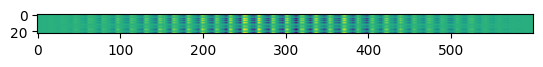

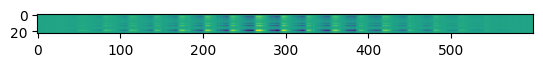

In [13]:
plt.imshow(np.load('synt_data/data_12/10.npy', allow_pickle=True))
plt.show()
plt.imshow(np.load('synt_data/data_10/10.npy', allow_pickle=True))
plt.show()


tensor(1., device='cuda:0', dtype=torch.float64)
tensor(1., device='cuda:0', dtype=torch.float64)
tensor(0., device='cuda:0', dtype=torch.float64)


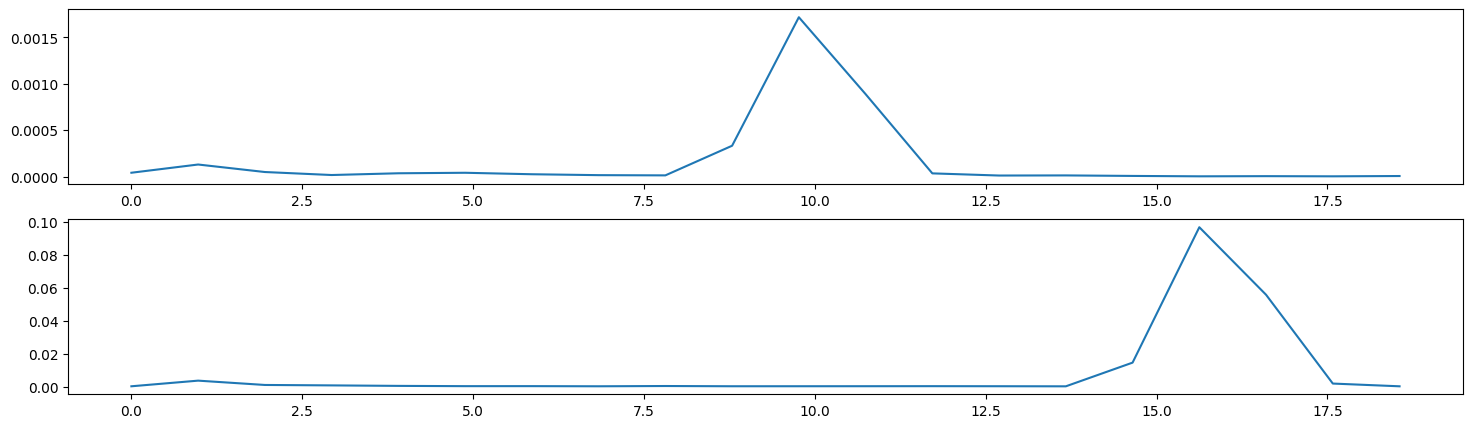

In [14]:
fig, ax = plt.subplots(2,1, figsize=(18, 5))


i=synt_loader_train.dataset[50]
# ax[0].imshow(i['anchor'], interpolation='nearest', aspect='auto')
# ax[0].plot(i['anchor'][:,20])
print(i['label'])
print(i['label'])
w = signal.welch(i['anchor'][:,20], fs=250)
ax[0].plot(w[0][:20], w[1].T[:20])

i=synt_loader_train.dataset[-234]
# ax[1].plot(i['anchor'][:,20])

# ax[1].imshow(i['anchor'], interpolation='nearest', aspect='auto')
w = signal.welch(i['anchor'][:,20], fs=250)
print(i['label'])


ax[1].plot(w[0][:20], w[1].T[:20])



# Fine-tuning the model

In [12]:
from transformers import TrainingArguments, Trainer

In [13]:
num_labels = 2
model = EEGEmbedder()
model.masking=False
model.clf=True
model.load_state_dict(torch.load('/media/hdd/pretraining/models/step.pt'), strict=False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias'], unexpected_keys=[])

In [14]:
from torch.optim.lr_scheduler import _LRScheduler
class NoamLR(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, d_model=512):
        self.warmup_steps = warmup_steps
        self.d_model = d_model
        super().__init__(optimizer)

    def get_lr(self):
        last_epoch = max(1, self.last_epoch)
        factor = min(last_epoch ** (-0.5), last_epoch * self.warmup_steps ** (-1.5))
        
        return [base_lr * self.d_model ** (-0.5) * factor for base_lr in self.base_lrs]

In [15]:
cossim = torch.nn.CosineSimilarity(dim=-1)

def cosloss(anchor, real, negative):
    a = torch.exp(cossim(anchor, real)) / 0.1
    b = sum([torch.exp(cossim(anchor, negative[:, n])) / 0.1 for n in range(negative.shape[1])]) + 1e-6
    return -torch.log(a/b)

In [16]:
# import random
# def worker_init_fn(worker_id):
#     torch_seed = torch.initial_seed()
#     random.seed(torch_seed + worker_id)
#     np.random.seed((torch_seed + worker_id) % 2**30)

# train_dataset = TEST(splitted_paths[:-15000])
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True, worker_init_fn = worker_init_fn)

# test_dataset = TEST(splitted_paths[-15000:])
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=True, worker_init_fn = worker_init_fn)

In [17]:
writer = SummaryWriter('logs')

In [18]:
def _calculate_similarity( z, c, negatives):
    c = c[..., :].permute([0, 2, 1]).unsqueeze(-2)
    z = z.permute([0, 2, 1]).unsqueeze(-2)

    # In case the contextualizer matches exactly, need to avoid divide by zero errors
    negative_in_target = (c == negatives).all(-1)
    targets = torch.cat([c, negatives], dim=-2)

    logits = torch.nn.functional.cosine_similarity(z, targets, dim=-1) / 0.1
    if negative_in_target.any():
        logits[1:][negative_in_target] = float("-inf")

    return logits.view(-1, logits.shape[-1])

def _generate_negatives(z):
    """Generate negative samples to compare each sequence location against"""
    num_negatives = 20
    batch_size, feat, full_len = z.shape
    z_k = z.permute([0, 2, 1]).reshape(-1, feat)
    with torch.no_grad():
        # candidates = torch.arange(full_len).unsqueeze(-1).expand(-1, self.num_negatives).flatten()
        negative_inds = torch.randint(0, full_len-1, size=(batch_size, full_len * num_negatives))
        # From wav2vec 2.0 implementation, I don't understand
        # negative_inds[negative_inds >= candidates] += 1

        for i in range(1, batch_size):
            negative_inds[i] += i * full_len

    z_k = z_k[negative_inds.view(-1)].view(batch_size, full_len, num_negatives, feat)
    return z_k, negative_inds

In [19]:
model.train()

lr_d = 2e-5
acc_size = 8
training_epochs1 = 100000 // len(synt_loader_train)

optim = torch.optim.AdamW(model.parameters(), lr=lr_d)

model_test = torch.nn.DataParallel(model)
model_test.to('cuda:0')

loss_func = torch.nn.MSELoss()
scheduler = NoamLR(optim, 100000, 512)

steps = 0

In [45]:
for epoch in range(training_epochs1):
    mean_loss = 0
    acc_step = 0
    for batch in synt_loader_train:
        # print(type(batch['anchor']))
        # print(batch['anchor'])
        # print()
        logits = model_test(
            batch['anchor'],#.to('cuda:0'), 
            None,
            batch['channels'].long(),
            clf=True)
        # ae, label = model_test(
        #     batch['anchor'],#.to('cuda:0'), 
        #     None, 
        #     batch['channels'].long(),
        #     clf=False
        # )
        # print(logits.shape, ae.shape, label.shape, torch.tensor(labels_).shape)

        label = batch['label'].to(torch.int64)#.gpu().detach()
        logits = logits.to(torch.int64)
        
#         logits = _calculate_similarity(torch.transpose(label, 1, 2), torch.transpose(logits, 1, 2), _generate_negatives(torch.transpose(label, 1, 2))[0])

#         labels_ = np.r_[labels_, sample['label'].cpu().detach().numpy()]
        loss = torch.nn.CrossEntropyLoss()(logits, label) #+ 0.001 * label.pow(2).mean()

        loss = loss.mean()
        loss.backward()
        mean_loss += loss.item()
        acc_step += 1
        steps += 1
        # raise
        if acc_step != 0 and acc_step % acc_size == 0:
            optim.step()
            scheduler.step()
            optim.zero_grad()
            if steps % 100 == 0:
                print('Loss/train\t{}'.format(mean_loss / acc_size))
            writer.add_scalar('Loss/train', mean_loss / acc_size, steps)
            mean_loss = 0
#         if steps != 0 and steps % 1000 == 0:
#             der = 0
#             try:
#                 with torch.no_grad():
#                     for batch in synt_loader_test:
#                         logits = model_test(batch['anchor'],#.to('cuda:0'), 
#                                             None,
#                                             batch['channels'].long(),
#                                             clf=True)
#                         label=batch['labels']
                        
#                         logits = _calculate_similarity(torch.transpose(label, 1, 2), torch.transpose(logits, 1, 2), _generate_negatives(torch.transpose(label, 1, 2))[0])

#                         labels_ = np.r_[labels_, sample['label'].cpu().detach().numpy()]

#                         loss = torch.nn.CrossEntropyLoss()(logits, labels_) + 0.001 * label.pow(2).mean()

#                         loss = loss.mean() / acc_size
#                         der += loss
#                 der /= len(test_loader)
#                 writer.add_scalar('Loss/test', der, steps)

#                 print('Loss: {}\t'.format(der))
#             except:
#                 raise
            # torch.save(model_test.module.state_dict(), 'models/step.pt'.format(steps))

RuntimeError: "host_softmax" not implemented for 'Long'

In [16]:
for epoch in range(training_epochs):
    mean_loss = 0
    acc_step = 0
    for batch in synt_loader_train:
        # print(type(batch['anchor']))
        # print(batch['anchor'])
        # print()
        logits = model_test(
            batch['anchor'],#.to('cuda:0'), 
            None,
            batch['channels'].long(),
            clf=True)
        # ae, label = model_test(
        #     batch['anchor'],#.to('cuda:0'), 
        #     None, 
        #     batch['channels'].long(),
        #     clf=False
        # )

        label = batch['label']
        logits = _calculate_similarity(torch.transpose(label, 1, 2), torch.transpose(logits, 1, 2), _generate_negatives(torch.transpose(label, 1, 2))[0])

        labels_ = np.r_[labels_, sample['label'].cpu().detach().numpy()]
        loss = torch.nn.CrossEntropyLoss()(logits, torch.tensor(labels_)) + 0.001 * label.pow(2).mean()

        loss = loss.mean()
        loss.backward()
        mean_loss += loss.item()
        acc_step += 1
        steps += 1
        # raise
        if acc_step != 0 and acc_step % acc_size == 0:
            optim.step()
            scheduler.step()
            optim.zero_grad()
            if steps % 100 == 0:
                print('Loss/train\t{}'.format(mean_loss / acc_size))
            writer.add_scalar('Loss/train', mean_loss / acc_size, steps)
            mean_loss = 0

NameError: name 'training_epochs' is not defined

In [49]:
label, logits

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 tensor([[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]], device='cuda:0'))